<a href="https://colab.research.google.com/github/yohanesnuwara/pyresim/blob/master/simulators/PyReSim2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
!git clone https://github.com/yohanesnuwara/pyresim

Cloning into 'pyresim'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (250/250), done.
remote: Total 1282 (delta 154), reused 0 (delta 0), pack-reused 1031
Receiving objects: 100% (1282/1282), 764.92 KiB | 1.01 MiB/s, done.
Resolving deltas: 100% (779/779), done.


In [3]:
import sys
sys.path.append('/content/pyresim/functions')

Function for Incompressible simulation

In [4]:
from input_output import read_input
from boundary import boundary2d_location, boundary_flow2d_constant_pressuregrad, boundary_floweq2d
from gridding import fill_active_blocks, source2d
from solver import lhs_coeffs2d_welltype, rhs_constant2d_welltype, fill2d_lhs_mat, fill2d_rhs_mat
from transmissibility import transmissibility2d, transmissibility2d_boundary
from wellblock import prodrate1d, fraction_wellblock_geometric_factor
from wellsimulation import solution_well2d
from potential import potential_term2d
from synthetics import create_depth2d

Additional functions for Slightly Compressible simulation

In [5]:
from wellsimulation import well2d_report_slicomp
from synthetics import synthetic_initial_pressure2d

## Incompressible Simulator

For `incompressible` simulation, `CFLUID` (fluid compressibility) and `CPORE` (pore compressibility) are set as 0 microsip. `B` (FVF) is 1. 



### Non-elevated

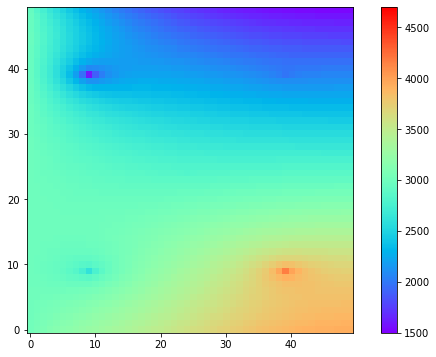

In [9]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate2d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate2d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

"""""""""""
RESERVOIR DEPTH

* If you have depth data (reservoir is ELEVATED), read the data using 
  'read_depth' function
* If you don't have and you want to simulate ELEVATED reservoir, 
  create your own synthetic data
* If you don't have and you want to simulate NON-ELEVATED reservoir, 
  create constant depth using 'create_depth2d'
"""""""""""

# create 2D synthetic depth 

z_array = create_depth2d(reservoir_input, model='horizontal',  z=3000.)
# z_array = create_depth2d(reservoir_input, model='anticline')
# z_array = create_depth2d(reservoir_input, model='dipping_to_north')

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']
yi = reservoir_input['yi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
ky = reservoir_input['ky']
B = reservoir_input['B']
mu = reservoir_input['mu']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_condition']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

" Create grid points "
# meshgrid the original points
x_ = np.arange(1, xi + 1)
y_ = np.arange(1, yi + 1)

x, y = np.meshgrid(x_, y_, indexing='ij')

" Handle irregularities "
# NOTHING. The grid is regular

" Classify the location of boundary with codes (1, 12, 13, etc) "
bound_loc = boundary2d_location(x, y, xi, yi)

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
qsc = source2d(well_value, np.array(well_loc), xi, yi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, ky, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create WELLBLOCK PROPERTY 
# inject (fill) the operating wells to 'qsc' grid that we created before
# the values won't be filled in the 'qsc' grid that has value = 0
qsc = qsc.astype('float')
qsc[qsc == 0] = np.nan

well_value = qsc
well_condition = fill_active_blocks(well_condition, qsc)
well_rw = fill_active_blocks(well_rw, qsc)
well_Gw = fill_active_blocks(np.array(Gw), qsc)
well_mu = fill_active_blocks(np.array(mu), qsc)
well_B = fill_active_blocks(np.array(B), qsc)

"""""""""""
SIMULATION
"""""""""""

def lookup(i, j, bound_dict):
    """
    Determine the type and value of boundary at a grid block
    given the boundary dictionary
    """
    if bound_dict['loc'] == 'all':
        bound_type = bound_dict['type']
        bound_value = bound_dict['value']
    else:
        x, y = i + 1, j + 1

        id1 = (np.where(np.all(bound_dict['loc'] == np.array([x, y]), axis=-1)))[0][0]
        id2 = (np.where(np.all((bound_dict['loc'][id1]) == np.array([x, y]), axis=-1)))[0][0]

        bound_type = (bound_dict['type'])[id1]
        bound_value = (bound_dict['value'])[id1]
    return bound_type, bound_value

# Create block index
block_index = np.arange(1, (xi * yi) + 1)
block_index = (np.reshape(block_index, (-1, xi))).T

# Create empty matrix for LHS and RHS
lhs_mat = np.array([[0.] * (xi * yi)] * (xi * yi))
rhs_mat = np.array([[0.] * 1] * (xi * yi))

for i in range(xi):
    for j in range(yi):

        if bound_loc[i, j] == 13:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3]),
                        'type': np.array([b1_type, b3_type]),
                        'value': np.array([b1_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 14:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 4]),
                        'type': np.array([b1_type, b4_type]),
                        'value': np.array([b1_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 23:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3]),
                        'type': np.array([b2_type, b3_type]),
                        'value': np.array([b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 24:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 4]),
                        'type': np.array([b2_type, b4_type]),
                        'value': np.array([b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 1:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1]),
                        'type': np.array([b1_type]),
                        'value': np.array([b1_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 2:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2]),
                        'type': np.array([b2_type]),
                        'value': np.array([b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 3:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3]),
                        'type': np.array([b3_type]),
                        'value': np.array([b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 4:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([4]),
                        'type': np.array([b4_type]),
                        'value': np.array([b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 0.0:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""
            # create boundary dictionary
            # no boundary
            boundary = {'loc': None,
                        'type': None,
                        'value': None}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}            

        """""""""""
        DO NOT MODIFY THIS
        """""""""""

        # calculate INTER-BLOCK transmissibilities
        T = transmissibility2d(dx, dy, dz, kx, ky, mu, B)
        T = np.array(T)

        # calculate BOUNDARY transmissibilities

        if bound_loc[i, j] == 0.0:
            # Interior blocks. All side are non-boundary, so flow are all inter-block
            T = T
            boundary['T'] = None

            # potential term for INNER BLOCKS is NOT ZERO. Has elevation from
            # neighboring blocks
            potential_term = potential_term2d(rho, T, z_array[i+1,j], z_array[i-1,j], 
                                              z_array[i,j-1], z_array[i,j+1], 
                                              z_array[i,j])
            
        else:
            # Boundary blocks.
            bound_T = []
            for k in range(len(boundary['loc'])):
                a = boundary['loc'][k]
                _ = transmissibility2d_boundary(boundary['loc'][k], boundary['type'][k],
                                                dx, dy, dz, kx, ky, mu, B)
                T[a - 1] = _
                bound_T.append(_)

            boundary['T'] = bound_T

            # potential term for BOUNDARY BLOCKS is ZERO. Elevation of the
            # boundary blocks equal to the boundary zone
            potential_term = 0        

        # calculate LHS coefficients
        px_min, px_plus, py_min, py_plus, p = lhs_coeffs2d_welltype(bound_loc[i, j],
                                                                    well, T, mu, B, 
                                                                    solver='incompressible') 

        # calculate RHS constants
        rhs = rhs_constant2d_welltype(boundary, well, potential_term, dx, dy, 
                                      dz, kx, ky, mu, B, solver='incompressible')

        # fill in LHS matrix
        lhs_mat = fill2d_lhs_mat(bound_loc[i, j], block_index[i, j], xi, lhs_mat,
                                 px_min, px_plus, py_min, py_plus, p)

        # fill in RHS matrix
        rhs_mat = fill2d_rhs_mat(block_index[i, j], rhs_mat, rhs)

"""""""""""
PRESSURE SOLVER
"""""""""""
p_sol = np.linalg.solve(lhs_mat, rhs_mat)

p_sol = p_sol.T.reshape(-1)

"""""""""""
DISPLAY PRESSURE
"""""""""""

# display well
xsc = np.array(well_loc)[:,0]
ysc = np.array(well_loc)[:,1]

p_sol = p_sol.reshape(-1, xi)
plt.figure(figsize=(10,6))
plt.imshow(p_sol, vmin=1500, vmax=4700, cmap='rainbow', origin='lower')
plt.colorbar()
# plt.scatter(xsc, ysc, color='black')
plt.show()

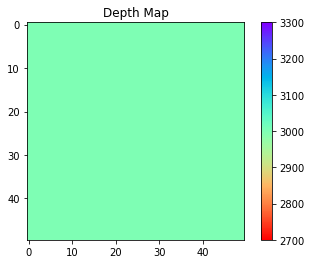

In [10]:
plt.imshow(z_array, cmap='rainbow_r')
plt.title('Depth Map')
plt.colorbar()
plt.show()

In [11]:
"""""""""""
WELL SIMULATION
"""""""""""

# create well dataframe
B = np.full(len(well_name), reservoir_input['B'])
mu = np.full(len(well_name), reservoir_input['mu'])
well_df = pd.DataFrame.from_dict(wells)
well_df['well_mu'], well_df['well_B'], well_df['well_Gw'] = mu, B, Gw

# print pressure in order (engineering notations: [0,0], [1,0], [2,0] as 1,2,3)
p_sol = p_sol.T

# FBHP and flow rate solution after pressure in each grid block solved
well_report = solution_well2d(well_df, p_sol)
well_report = well_df.drop(['well_mu', 'well_B', 'well_Gw'], axis=1)
well_report

,well_name,well_loc,well_rw,well_skin,well_condition,well_value,well_config,fbhp_sol,rate_sol
0,A,"[10, 10]",3.0,0.0,constant_fbhp,2000.0,0.0,2000.000000,-2459.838800
1,B,"[40, 40]",3.5,0.5,constant_rate,-600.0,0.0,1829.524191,-600.000000
2,C,"[10, 40]",4.0,0.0,constant_rate,350.0,0.0,1693.723877,350.000000
3,D,"[40, 10]",3.0,0.0,constant_fbhp,3000.0,0.0,3000.000000,-4645.809559
4,E,"[25, 25]",2.5,1.0,constant_rate,-150.0,0.0,2776.645130,-150.000000


### Elevated 

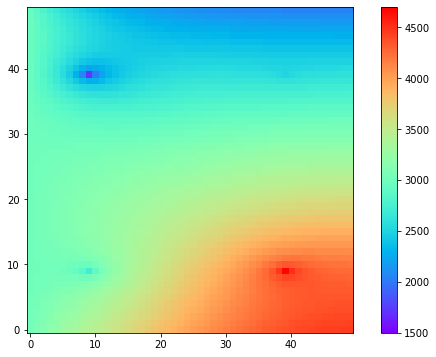

In [6]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate2d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

"""""""""""
RESERVOIR DEPTH

* If you have depth data (reservoir is ELEVATED), read the data using 
  'read_depth' function
* If you don't have and you want to simulate ELEVATED reservoir, 
  create your own synthetic data
* If you don't have and you want to simulate NON-ELEVATED reservoir, 
  create constant depth using 'create_depth2d'
"""""""""""

# create 2D synthetic depth 

# z_array = create_depth2d(reservoir_input, model='horizontal',  z=3000.)
z_array = create_depth2d(reservoir_input, model='anticline')
# z_array = create_depth2d(reservoir_input, model='dipping_to_north')

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']
yi = reservoir_input['yi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
ky = reservoir_input['ky']
B = reservoir_input['B']
mu = reservoir_input['mu']
rho = reservoir_input['rho']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_condition']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

" Create grid points "
# meshgrid the original points
x_ = np.arange(1, xi + 1)
y_ = np.arange(1, yi + 1)

x, y = np.meshgrid(x_, y_, indexing='ij')

" Handle irregularities "
# NOTHING. The grid is regular

" Classify the location of boundary with codes (1, 12, 13, etc) "
bound_loc = boundary2d_location(x, y, xi, yi)

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
qsc = source2d(well_value, np.array(well_loc), xi, yi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, ky, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create WELLBLOCK PROPERTY 
# inject (fill) the operating wells to 'qsc' grid that we created before
# the values won't be filled in the 'qsc' grid that has value = 0
qsc = qsc.astype('float')
qsc[qsc == 0] = np.nan

well_value = qsc
well_condition = fill_active_blocks(well_condition, qsc)
well_rw = fill_active_blocks(well_rw, qsc)
well_Gw = fill_active_blocks(np.array(Gw), qsc)
well_mu = fill_active_blocks(np.array(mu), qsc)
well_B = fill_active_blocks(np.array(B), qsc)

"""""""""""
SIMULATION
"""""""""""

def lookup(i, j, bound_dict):
    """
    Determine the type and value of boundary at a grid block
    given the boundary dictionary
    """
    if bound_dict['loc'] == 'all':
        bound_type = bound_dict['type']
        bound_value = bound_dict['value']
    else:
        x, y = i + 1, j + 1

        id1 = (np.where(np.all(bound_dict['loc'] == np.array([x, y]), axis=-1)))[0][0]
        id2 = (np.where(np.all((bound_dict['loc'][id1]) == np.array([x, y]), axis=-1)))[0][0]

        bound_type = (bound_dict['type'])[id1]
        bound_value = (bound_dict['value'])[id1]
    return bound_type, bound_value

# Create block index
block_index = np.arange(1, (xi * yi) + 1)
block_index = (np.reshape(block_index, (-1, xi))).T

# Create empty matrix for LHS and RHS
lhs_mat = np.array([[0.] * (xi * yi)] * (xi * yi))
rhs_mat = np.array([[0.] * 1] * (xi * yi))

for i in range(xi):
    for j in range(yi):

        if bound_loc[i, j] == 13:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3]),
                        'type': np.array([b1_type, b3_type]),
                        'value': np.array([b1_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 14:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 4]),
                        'type': np.array([b1_type, b4_type]),
                        'value': np.array([b1_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 23:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3]),
                        'type': np.array([b2_type, b3_type]),
                        'value': np.array([b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 24:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 4]),
                        'type': np.array([b2_type, b4_type]),
                        'value': np.array([b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 1:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1]),
                        'type': np.array([b1_type]),
                        'value': np.array([b1_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 2:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2]),
                        'type': np.array([b2_type]),
                        'value': np.array([b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 3:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3]),
                        'type': np.array([b3_type]),
                        'value': np.array([b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 4:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([4]),
                        'type': np.array([b4_type]),
                        'value': np.array([b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 0.0:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""
            # create boundary dictionary
            # no boundary
            boundary = {'loc': None,
                        'type': None,
                        'value': None}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}            

        """""""""""
        DO NOT MODIFY THIS
        """""""""""

        # calculate INTER-BLOCK transmissibilities
        T = transmissibility2d(dx, dy, dz, kx, ky, mu, B)
        T = np.array(T)

        # calculate BOUNDARY transmissibilities

        if bound_loc[i, j] == 0.0:
            # Interior blocks. All side are non-boundary, so flow are all inter-block
            T = T
            boundary['T'] = None

            # potential term for INNER BLOCKS is NOT ZERO. Has elevation from
            # neighboring blocks
            potential_term = potential_term2d(rho, T, z_array[i+1,j], z_array[i-1,j], 
                                              z_array[i,j-1], z_array[i,j+1], 
                                              z_array[i,j])
            
        else:
            # Boundary blocks.
            bound_T = []
            for k in range(len(boundary['loc'])):
                a = boundary['loc'][k]
                _ = transmissibility2d_boundary(boundary['loc'][k], boundary['type'][k],
                                                dx, dy, dz, kx, ky, mu, B)
                T[a - 1] = _
                bound_T.append(_)

            boundary['T'] = bound_T

            # potential term for BOUNDARY BLOCKS is ZERO. Elevation of the
            # boundary blocks equal to the boundary zone
            potential_term = 0

        # calculate LHS coefficients
        px_min, px_plus, py_min, py_plus, p = lhs_coeffs2d_welltype(bound_loc[i, j],
                                                                    well, T, mu, B, 
                                                                    solver='incompressible') 

        # calculate RHS constants
        rhs = rhs_constant2d_welltype(boundary, well, potential_term, dx, dy, 
                                      dz, kx, ky, mu, B, solver='incompressible')

        # fill in LHS matrix
        lhs_mat = fill2d_lhs_mat(bound_loc[i, j], block_index[i, j], xi, lhs_mat,
                                 px_min, px_plus, py_min, py_plus, p)

        # fill in RHS matrix
        rhs_mat = fill2d_rhs_mat(block_index[i, j], rhs_mat, rhs)

"""""""""""
PRESSURE SOLVER
"""""""""""
p_sol = np.linalg.solve(lhs_mat, rhs_mat)

p_sol = p_sol.T.reshape(-1)

"""""""""""
DISPLAY PRESSURE
"""""""""""

# display well
xsc = np.array(well_loc)[:,0]
ysc = np.array(well_loc)[:,1]

p_sol = p_sol.reshape(-1, xi)
plt.figure(figsize=(10,6))
plt.imshow(p_sol, vmin=1500, vmax=4700, cmap='rainbow', origin='lower')
plt.colorbar()
# plt.scatter(xsc, ysc, color='black')
plt.show()

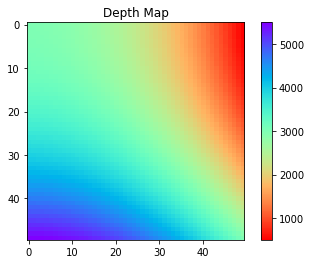

In [7]:
plt.imshow(z_array, cmap='rainbow_r')
plt.title('Depth Map')
plt.colorbar()
plt.show()

In [8]:
"""""""""""
WELL SIMULATION
"""""""""""

# create well dataframe
B = np.full(len(well_name), reservoir_input['B'])
mu = np.full(len(well_name), reservoir_input['mu'])
well_df = pd.DataFrame.from_dict(wells)
well_df['well_mu'], well_df['well_B'], well_df['well_Gw'] = mu, B, Gw

# print pressure in order (engineering notations: [0,0], [1,0], [2,0] as 1,2,3)
p_sol = p_sol.T

# FBHP and flow rate solution after pressure in each grid block solved
well_report = solution_well2d(well_df, p_sol)
well_report = well_df.drop(['well_mu', 'well_B', 'well_Gw'], axis=1)
well_report

,well_name,well_loc,well_rw,well_skin,well_condition,well_value,well_config,fbhp_sol,rate_sol
0,A,"[10, 10]",3.0,0.0,constant_fbhp,2000.0,0.0,2000.000000,-2861.301525
1,B,"[40, 40]",3.5,0.5,constant_rate,-600.0,0.0,2342.913313,-600.000000
2,C,"[10, 40]",4.0,0.0,constant_rate,350.0,0.0,1794.801386,350.000000
3,D,"[40, 10]",3.0,0.0,constant_fbhp,3000.0,0.0,3000.000000,-6688.554541
4,E,"[25, 25]",2.5,1.0,constant_rate,-150.0,0.0,3181.088277,-150.000000


## Slightly compressible Simulator

For `slicomp` simulation, `CFLUID` is increased to 10 microsip, `CPORE` increased to 1 microsip, and `B` increased to 1.5.

### Non-elevated

In [23]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate2d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

"""""""""""
SLIGHTLY INCOMPRESSIBLE INPUTS
"""""""""""

# initialize pressure (if you don't have data, create your own synthetic data,
# using function 'synthetic_initial_pressure2d'. In this case, set 4,000 psi.
p_initial = synthetic_initial_pressure2d(reservoir_input['xi'], reservoir_input['yi'],
                                         function='equilibrize', p_ref=4000)

timestep = 1 # time increment, day
schedule = 20 # how long will be simulated, days

"""""""""""
RESERVOIR DEPTH

* If you have depth data (reservoir is ELEVATED), read the data using 
  'read_depth' function
* If you don't have and you want to simulate ELEVATED reservoir, 
  create your own synthetic data
* If you don't have and you want to simulate NON-ELEVATED reservoir, 
  create constant depth using 'create_depth2d'
"""""""""""

# create 2D synthetic depth 

z_array = create_depth2d(reservoir_input, model='horizontal',  z=3000.)
# z_array = create_depth2d(reservoir_input, model='anticline')
# z_array = create_depth2d(reservoir_input, model='dipping_to_north')

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']
yi = reservoir_input['yi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
ky = reservoir_input['ky']
B = reservoir_input['B']
mu = reservoir_input['mu']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_condition']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

" Create grid points "
# meshgrid the original points
x_ = np.arange(1, xi + 1)
y_ = np.arange(1, yi + 1)

x, y = np.meshgrid(x_, y_, indexing='ij')

" Handle irregularities "
# NOTHING. The grid is regular

" Classify the location of boundary with codes (1, 12, 13, etc) "
bound_loc = boundary2d_location(x, y, xi, yi)

" For Slightly Incompressible sim, there are information of CFLUID and CPORE "

# convert unit microsip to sip (* 10^-6)
reservoir_input['cfluid'] = reservoir_input['cfluid'] * 1E-6
reservoir_input['cpore'] = reservoir_input['cpore'] * 1E-6

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
qsc = source2d(well_value, np.array(well_loc), xi, yi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, ky, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create WELLBLOCK PROPERTY 
# inject (fill) the operating wells to 'qsc' grid that we created before
# the values won't be filled in the 'qsc' grid that has value = 0
qsc = qsc.astype('float')
qsc[qsc == 0] = np.nan

well_value = qsc
well_condition = fill_active_blocks(well_condition, qsc)
well_rw = fill_active_blocks(well_rw, qsc)
well_Gw = fill_active_blocks(np.array(Gw), qsc)
well_mu = fill_active_blocks(np.array(mu), qsc)
well_B = fill_active_blocks(np.array(B), qsc)

"""""""""""
SIMULATION
"""""""""""

def lookup(i, j, bound_dict):
    """
    Determine the type and value of boundary at a grid block
    given the boundary dictionary
    """
    if bound_dict['loc'] == 'all':
        bound_type = bound_dict['type']
        bound_value = bound_dict['value']
    else:
        x, y = i + 1, j + 1

        id1 = (np.where(np.all(bound_dict['loc'] == np.array([x, y]), axis=-1)))[0][0]
        id2 = (np.where(np.all((bound_dict['loc'][id1]) == np.array([x, y]), axis=-1)))[0][0]

        bound_type = (bound_dict['type'])[id1]
        bound_value = (bound_dict['value'])[id1]
    return bound_type, bound_value

# Create block index
block_index = np.arange(1, (xi * yi) + 1)
block_index = (np.reshape(block_index, (-1, xi))).T

# Create empty matrix for LHS and RHS
lhs_mat = np.array([[0.] * (xi * yi)] * (xi * yi))

# set up empty array for transmissibility, well and boundary dictionary of each block 
# for later computation of RHS and pressure solve at each timestep
T_array = np.zeros((yi, xi, 4))
well_dict = np.array([[0.] * yi] * xi).astype(dict)
boundary_dict = np.array([[0.] * yi] * xi).astype(dict)

" Start simulation "

for i in range(xi):
    for j in range(yi):

        if bound_loc[i, j] == 13:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3]),
                        'type': np.array([b1_type, b3_type]),
                        'value': np.array([b1_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 14:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 4]),
                        'type': np.array([b1_type, b4_type]),
                        'value': np.array([b1_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 23:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3]),
                        'type': np.array([b2_type, b3_type]),
                        'value': np.array([b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 24:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 4]),
                        'type': np.array([b2_type, b4_type]),
                        'value': np.array([b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 1:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1]),
                        'type': np.array([b1_type]),
                        'value': np.array([b1_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 2:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2]),
                        'type': np.array([b2_type]),
                        'value': np.array([b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 3:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3]),
                        'type': np.array([b3_type]),
                        'value': np.array([b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 4:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([4]),
                        'type': np.array([b4_type]),
                        'value': np.array([b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 0.0:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""
            # create boundary dictionary
            # no boundary
            boundary = {'loc': None,
                        'type': None,
                        'value': None}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}            

        """""""""""
        DO NOT MODIFY THIS
        """""""""""

        # calculate INTER-BLOCK transmissibilities
        T = transmissibility2d(dx, dy, dz, kx, ky, mu, B)
        T = np.array(T)

        # calculate BOUNDARY transmissibilities

        if bound_loc[i, j] == 0.0:
            # Interior blocks. All side are non-boundary, so flow are all inter-block
            T = T
            boundary['T'] = None

        else:
            # Boundary blocks.
            bound_T = []
            for k in range(len(boundary['loc'])):
                a = boundary['loc'][k]
                _ = transmissibility2d_boundary(boundary['loc'][k], boundary['type'][k],
                                                dx, dy, dz, kx, ky, mu, B)
                T[a - 1] = _
                bound_T.append(_)

            boundary['T'] = bound_T

        # calculate LHS coefficients
        px_min, px_plus, py_min, py_plus, p = lhs_coeffs2d_welltype(bound_loc[i, j],
                                                                    well, T, mu, B, 
                                                                    solver='slicomp',
                                                                    reservoir_input=reservoir_input,
                                                                    timestep=1)
        T_array[i,j] = T
        well_dict[i,j] = well
        boundary_dict[i,j] = boundary

        # fill in LHS matrix
        lhs_mat = fill2d_lhs_mat(bound_loc[i, j], block_index[i, j], xi, lhs_mat,
                                 px_min, px_plus, py_min, py_plus, p)                

" Timestep evolution of computing RHS and solving the pressure "

# initiate solution pressure with the initial pressure array (p_initial)
p_sol = p_initial

p_sol_record = []
for k in range(schedule):

  rhs_mat = np.array([[0.] * 1] * (xi * yi))
  for i in range(xi):
    for j in range(yi):
          # the pressure in grid block. FIRST timestep, it equals 'p_initial'
          # the NEXT timesteps, it equals the solved and updated pressure   
          p_sol = p_sol

          # calculate potential term 

          if bound_loc[i, j] == 0.0:
              # Interior blocks.

              # potential term for INNER BLOCKS is NOT ZERO. Has elevation from
              # neighboring blocks
              potential_term = potential_term2d(rho, T_array[i,j], z_array[i+1,j], z_array[i-1,j], 
                                                z_array[i,j-1], z_array[i,j+1], 
                                                z_array[i,j])
          else:
              # Boundary blocks.

              # potential term for BOUNDARY BLOCKS is ZERO. Elevation of the
              # boundary blocks equal to the boundary zone
              potential_term = 0        

          # calculate RHS constants
          rhs = rhs_constant2d_welltype(boundary_dict[i,j], well_dict[i,j], 
                                        potential_term, dx, dy, dz, kx, ky, mu, B,
                                        solver='slicomp', p_initial=p_sol[i,j], 
                                        reservoir_input=reservoir_input,
                                        timestep=timestep)   
          # fill in RHS matrix
          rhs_mat = fill2d_rhs_mat(block_index[i, j], rhs_mat, rhs) 

  """""""""""
  PRESSURE SOLVER
  """""""""""
  p_sol = np.linalg.solve(lhs_mat, rhs_mat)
  p_sol = p_sol.T.reshape(-1)
  p_sol = p_sol.reshape(-1, xi)  
  
  p_sol_record.append(p_sol) 

"""""""""""
OUTPUT
""""""""""" 

p_initial = p_initial.reshape((1,xi,yi))
p_sol = np.concatenate((p_initial, p_sol_record), axis=0)

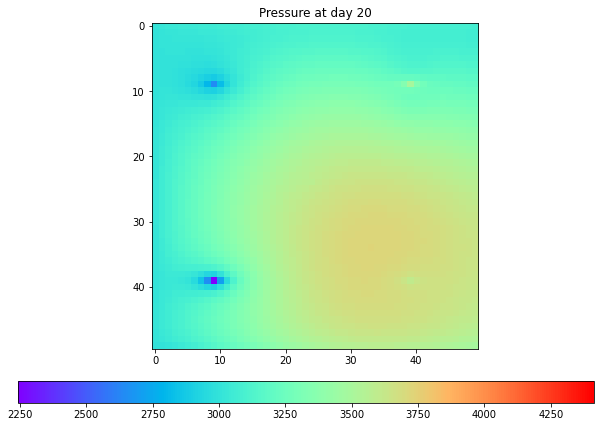

In [24]:
"""
PRESSURE AT CERTAIN DAY
"""
day = 20

min, max = np.round(np.amin(p_sol)), np.round(np.amax(p_sol))

fig, ax = plt.subplots(figsize=(10,6))  
im = ax.imshow(p_sol[day], cmap='rainbow', vmin=min, vmax=max)
ax.set_title('Pressure at day {}'.format(day))
cax = fig.add_axes([0.1, 0, 0.8, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

In [25]:
"""""""""""
INTERACTIVE ANIMATION (EVOLUTION OF PRESSURE)
"""""""""""

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets

min, max = np.round(np.amin(p_sol)), np.round(np.amax(p_sol))

@interact

def display_pressure(day=(0, schedule)):
  fig, ax = plt.subplots(figsize=(10,6))  
  im = ax.imshow(p_sol[day], cmap='rainbow', vmin=min, vmax=max)
  ax.set_title('Pressure at day {}'.format(day))
  cax = fig.add_axes([0.1, 0, 0.8, 0.05])
  fig.colorbar(im, cax=cax, orientation='horizontal')

  plt.show() 

interactive(children=(IntSlider(value=10, description='day', max=20), Output()), _dom_classes=('widget-interac…

In [26]:
"""""""""""
WELL SIMULATION
"""""""""""

# create well dataframe
B = np.full(len(well_name), reservoir_input['B'])
mu = np.full(len(well_name), reservoir_input['mu'])
well_df = pd.DataFrame.from_dict(wells)
well_df['well_mu'], well_df['well_B'], well_df['well_Gw'] = mu, B, Gw

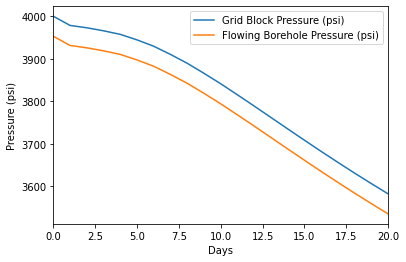

,time (day),grid block pressure (psi),fbhp_sol (psi),rate_sol (STB/D)
0,0,4000.000000,3952.870061,-150.0
1,1,3978.395843,3931.265904,-150.0
2,2,3972.846846,3925.716907,-150.0
3,3,3965.752775,3918.622836,-150.0
4,4,3957.357316,3910.227377,-150.0
5,5,3944.371976,3897.242037,-150.0
6,6,3929.374022,3882.244083,-150.0
7,7,3910.171141,3863.041202,-150.0
8,8,3889.360353,3842.230414,-150.0
9,9,3865.730132,3818.600193,-150.0


In [27]:
# input the name of well of interest
well_name = 'E'
well_report = well2d_report_slicomp(well_name, well_df, p_sol, schedule=schedule)

plt.plot(well_report['time (day)'], well_report['grid block pressure (psi)'], label='Grid Block Pressure (psi)')
plt.plot(well_report['time (day)'], well_report['fbhp_sol (psi)'], label='Flowing Borehole Pressure (psi)')
plt.xlabel('Days'); plt.ylabel('Pressure (psi)')
plt.xlim(0, schedule)
plt.legend()
plt.show()

well_report

### Elevated

In [18]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

"""""""""""
PUT THE INPUT TXT DATA
"""""""""""

filepath = '/content/pyresim/input/intermediate/intermediate2d_input.txt'

# call the read_input function to read input data
reservoir_input, wells, west_boundary, east_boundary, south_boundary, north_boundary = read_input(filepath)

"""""""""""
SLIGHTLY INCOMPRESSIBLE INPUTS
"""""""""""

# initialize pressure (if you don't have data, create your own synthetic data,
# using function 'synthetic_initial_pressure2d'. In this case, set 4,000 psi.
p_initial = synthetic_initial_pressure2d(reservoir_input['xi'], reservoir_input['yi'],
                                         function='equilibrize', p_ref=4000)

timestep = 1 # time increment, day
schedule = 20 # how long will be simulated, days

"""""""""""
RESERVOIR DEPTH

* If you have depth data (reservoir is ELEVATED), read the data using 
  'read_depth' function
* If you don't have and you want to simulate ELEVATED reservoir, 
  create your own synthetic data
* If you don't have and you want to simulate NON-ELEVATED reservoir, 
  create constant depth using 'create_depth2d'
"""""""""""

# create 2D synthetic depth 

# z_array = create_depth2d(reservoir_input, model='horizontal',  z=3000.)
z_array = create_depth2d(reservoir_input, model='anticline')
# z_array = create_depth2d(reservoir_input, model='dipping_to_north')

"""""""""""
INPUT PROCESSING
"""""""""""

# number of blocks in x and y
xi = reservoir_input['xi']
yi = reservoir_input['yi']

# define parameters, in this case blocks are homogeneous and same in size
dx = reservoir_input['dx'] 
dy = reservoir_input['dy']
dz = reservoir_input['dz']
kx = reservoir_input['kx']
ky = reservoir_input['ky']
B = reservoir_input['B']
mu = reservoir_input['mu']

# well information (dataframe)
well_name = wells['well_name']
well_rw = wells['well_rw'] / 12  # wellbore radius, inch to ft
well_skin = wells['well_skin']
well_loc = wells['well_loc']
well_condition = wells['well_condition']
well_value = wells['well_value']
well_config = wells['well_config']

"""""""""""
GRIDDING
"""""""""""

" Create grid points "
# meshgrid the original points
x_ = np.arange(1, xi + 1)
y_ = np.arange(1, yi + 1)

x, y = np.meshgrid(x_, y_, indexing='ij')

" Handle irregularities "
# NOTHING. The grid is regular

" Classify the location of boundary with codes (1, 12, 13, etc) "
bound_loc = boundary2d_location(x, y, xi, yi)

" For Slightly Incompressible sim, there are information of CFLUID and CPORE "

# convert unit microsip to sip (* 10^-6)
reservoir_input['cfluid'] = reservoir_input['cfluid'] * 1E-6
reservoir_input['cpore'] = reservoir_input['cpore'] * 1E-6

"""""""""""
WELL INFORMATION PROCESSING
"""""""""""

# source block (production or injection well)
qsc = source2d(well_value, np.array(well_loc), xi, yi)  # call function HERE

# Calculate wellblock geometric factor
kh, r_eq, Gw = [], [], []

for i in range(len(well_config)):
    kh_, r_eq_, Gw_ = fraction_wellblock_geometric_factor(dx, dy, kx, ky, well_skin[i],
                                                          well_rw[i], dz, well_config[i])
    kh.append(kh_);
    r_eq.append(r_eq_);
    Gw.append(Gw_)

# create WELLBLOCK PROPERTY 
# inject (fill) the operating wells to 'qsc' grid that we created before
# the values won't be filled in the 'qsc' grid that has value = 0
qsc = qsc.astype('float')
qsc[qsc == 0] = np.nan

well_value = qsc
well_condition = fill_active_blocks(well_condition, qsc)
well_rw = fill_active_blocks(well_rw, qsc)
well_Gw = fill_active_blocks(np.array(Gw), qsc)
well_mu = fill_active_blocks(np.array(mu), qsc)
well_B = fill_active_blocks(np.array(B), qsc)

"""""""""""
SIMULATION
"""""""""""

def lookup(i, j, bound_dict):
    """
    Determine the type and value of boundary at a grid block
    given the boundary dictionary
    """
    if bound_dict['loc'] == 'all':
        bound_type = bound_dict['type']
        bound_value = bound_dict['value']
    else:
        x, y = i + 1, j + 1

        id1 = (np.where(np.all(bound_dict['loc'] == np.array([x, y]), axis=-1)))[0][0]
        id2 = (np.where(np.all((bound_dict['loc'][id1]) == np.array([x, y]), axis=-1)))[0][0]

        bound_type = (bound_dict['type'])[id1]
        bound_value = (bound_dict['value'])[id1]
    return bound_type, bound_value

# Create block index
block_index = np.arange(1, (xi * yi) + 1)
block_index = (np.reshape(block_index, (-1, xi))).T

# Create empty matrix for LHS and RHS
lhs_mat = np.array([[0.] * (xi * yi)] * (xi * yi))

# set up empty array for transmissibility, well and boundary dictionary of each block 
# for later computation of RHS and pressure solve at each timestep
T_array = np.zeros((yi, xi, 4))
well_dict = np.array([[0.] * yi] * xi).astype(dict)
boundary_dict = np.array([[0.] * yi] * xi).astype(dict)

" Start simulation "

for i in range(xi):
    for j in range(yi):

        if bound_loc[i, j] == 13:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 3]),
                        'type': np.array([b1_type, b3_type]),
                        'value': np.array([b1_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 14:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1, 4]),
                        'type': np.array([b1_type, b4_type]),
                        'value': np.array([b1_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 23:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 3]),
                        'type': np.array([b2_type, b3_type]),
                        'value': np.array([b2_value, b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 24:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2, 4]),
                        'type': np.array([b2_type, b4_type]),
                        'value': np.array([b2_value, b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 1:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b1_type, b1_value = lookup(i, j, west_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([1]),
                        'type': np.array([b1_type]),
                        'value': np.array([b1_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 2:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b2_type, b2_value = lookup(i, j, east_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([2]),
                        'type': np.array([b2_type]),
                        'value': np.array([b2_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 3:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b3_type, b3_value = lookup(i, j, south_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([3]),
                        'type': np.array([b3_type]),
                        'value': np.array([b3_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 4:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""

            # get the TYPE and VALUE of the boundary from the BOUNDARY DICTIONARY
            b4_type, b4_value = lookup(i, j, north_boundary)

            # create boundary dictionary
            boundary = {'loc': np.array([4]),
                        'type': np.array([b4_type]),
                        'value': np.array([b4_value])}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}

        if bound_loc[i, j] == 0.0:
            """""""""""
            MODIFY THIS W.R.T. THE GRID BLOCK LOCATION 
            """""""""""
            # create boundary dictionary
            # no boundary
            boundary = {'loc': None,
                        'type': None,
                        'value': None}

            # create non-boundary dictionary
            non_boundary = {'loc': np.array([1, 2, 3, 4])}

            # create well dictionary
            well = {'condition': well_condition[i, j],
                    'value': well_value[i, j],
                    'rw': well_rw[i, j],
                    'Gw': well_Gw[i, j]}            

        """""""""""
        DO NOT MODIFY THIS
        """""""""""

        # calculate INTER-BLOCK transmissibilities
        T = transmissibility2d(dx, dy, dz, kx, ky, mu, B)
        T = np.array(T)

        # calculate BOUNDARY transmissibilities

        if bound_loc[i, j] == 0.0:
            # Interior blocks. All side are non-boundary, so flow are all inter-block
            T = T
            boundary['T'] = None

        else:
            # Boundary blocks.
            bound_T = []
            for k in range(len(boundary['loc'])):
                a = boundary['loc'][k]
                _ = transmissibility2d_boundary(boundary['loc'][k], boundary['type'][k],
                                                dx, dy, dz, kx, ky, mu, B)
                T[a - 1] = _
                bound_T.append(_)

            boundary['T'] = bound_T

        # calculate LHS coefficients
        px_min, px_plus, py_min, py_plus, p = lhs_coeffs2d_welltype(bound_loc[i, j],
                                                                    well, T, mu, B, 
                                                                    solver='slicomp',
                                                                    reservoir_input=reservoir_input,
                                                                    timestep=1)
        T_array[i,j] = T
        well_dict[i,j] = well
        boundary_dict[i,j] = boundary

        # fill in LHS matrix
        lhs_mat = fill2d_lhs_mat(bound_loc[i, j], block_index[i, j], xi, lhs_mat,
                                 px_min, px_plus, py_min, py_plus, p)                

" Timestep evolution of computing RHS and solving the pressure "

# initiate solution pressure with the initial pressure array (p_initial)
p_sol = p_initial

p_sol_record = []
for k in range(schedule):

  rhs_mat = np.array([[0.] * 1] * (xi * yi))
  for i in range(xi):
    for j in range(yi):
          # the pressure in grid block. FIRST timestep, it equals 'p_initial'
          # the NEXT timesteps, it equals the solved and updated pressure   
          p_sol = p_sol

          # calculate potential term 

          if bound_loc[i, j] == 0.0:
              # Interior blocks.

              # potential term for INNER BLOCKS is NOT ZERO. Has elevation from
              # neighboring blocks
              potential_term = potential_term2d(rho, T_array[i,j], z_array[i+1,j], z_array[i-1,j], 
                                                z_array[i,j-1], z_array[i,j+1], 
                                                z_array[i,j])
          else:
              # Boundary blocks.

              # potential term for BOUNDARY BLOCKS is ZERO. Elevation of the
              # boundary blocks equal to the boundary zone
              potential_term = 0        

          # calculate RHS constants
          rhs = rhs_constant2d_welltype(boundary_dict[i,j], well_dict[i,j], 
                                        potential_term, dx, dy, dz, kx, ky, mu, B,
                                        solver='slicomp', p_initial=p_sol[i,j], 
                                        reservoir_input=reservoir_input,
                                        timestep=timestep)   
          # fill in RHS matrix
          rhs_mat = fill2d_rhs_mat(block_index[i, j], rhs_mat, rhs) 

  """""""""""
  PRESSURE SOLVER
  """""""""""
  p_sol = np.linalg.solve(lhs_mat, rhs_mat)
  p_sol = p_sol.T.reshape(-1)
  p_sol = p_sol.reshape(-1, xi)  
  
  p_sol_record.append(p_sol) 

"""""""""""
OUTPUT
""""""""""" 

p_initial = p_initial.reshape((1,xi,yi))
p_sol = np.concatenate((p_initial, p_sol_record), axis=0)

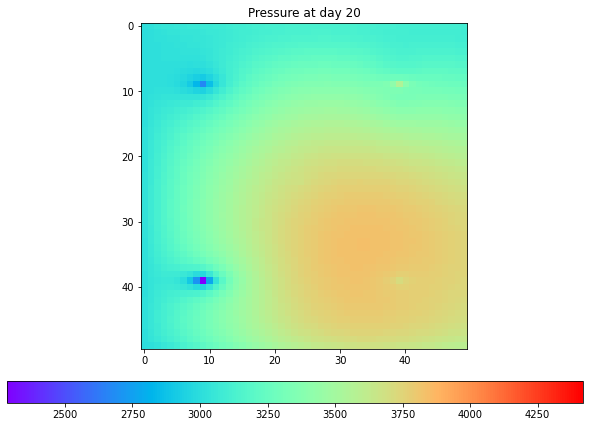

In [19]:
"""
PRESSURE AT CERTAIN DAY
"""
day = 20

min, max = np.round(np.amin(p_sol)), np.round(np.amax(p_sol))

fig, ax = plt.subplots(figsize=(10,6))  
im = ax.imshow(p_sol[day], cmap='rainbow', vmin=min, vmax=max)
ax.set_title('Pressure at day {}'.format(day))
cax = fig.add_axes([0.1, 0, 0.8, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

In [20]:
"""""""""""
INTERACTIVE ANIMATION (EVOLUTION OF PRESSURE)
"""""""""""

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, ToggleButtons
import ipywidgets as widgets

min, max = np.round(np.amin(p_sol)), np.round(np.amax(p_sol))

@interact

def display_pressure(day=(0, schedule)):
  fig, ax = plt.subplots(figsize=(10,6))  
  im = ax.imshow(p_sol[day], cmap='rainbow', vmin=min, vmax=max)
  ax.set_title('Pressure at day {}'.format(day))
  cax = fig.add_axes([0.1, 0, 0.8, 0.05])
  fig.colorbar(im, cax=cax, orientation='horizontal')

  plt.show() 

interactive(children=(IntSlider(value=10, description='day', max=20), Output()), _dom_classes=('widget-interac…

In [21]:
"""""""""""
WELL SIMULATION
"""""""""""

# create well dataframe
B = np.full(len(well_name), reservoir_input['B'])
mu = np.full(len(well_name), reservoir_input['mu'])
well_df = pd.DataFrame.from_dict(wells)
well_df['well_mu'], well_df['well_B'], well_df['well_Gw'] = mu, B, Gw

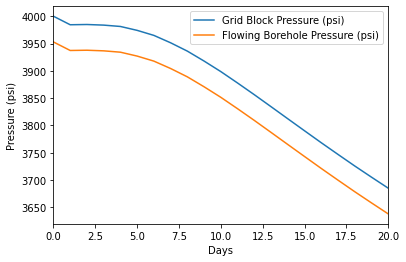

,time (day),grid block pressure (psi),fbhp_sol (psi),rate_sol (STB/D)
0,0,4000.000000,3952.870061,-150.0
1,1,3984.412366,3937.282427,-150.0
2,2,3984.867295,3937.737356,-150.0
3,3,3983.742447,3936.612508,-150.0
4,4,3981.269850,3934.139911,-150.0
5,5,3974.133073,3927.003134,-150.0
6,6,3964.897820,3917.767881,-150.0
7,7,3951.349160,3904.219221,-150.0
8,8,3936.076817,3888.946878,-150.0
9,9,3917.855680,3870.725741,-150.0


In [22]:
# input the name of well of interest
well_name = 'E'
well_report = well2d_report_slicomp(well_name, well_df, p_sol, schedule=schedule)

plt.plot(well_report['time (day)'], well_report['grid block pressure (psi)'], label='Grid Block Pressure (psi)')
plt.plot(well_report['time (day)'], well_report['fbhp_sol (psi)'], label='Flowing Borehole Pressure (psi)')
plt.xlabel('Days'); plt.ylabel('Pressure (psi)')
plt.xlim(0, schedule)
plt.legend()
plt.show()

well_report